#Graphene Mechanical Property Prediction using GNNs


##Phase 1 implementation — generating the 500 synthetic datasets.

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm pillow torchmetrics torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os, sys

In [ ]:
DRIVE_DIR = "/content/drive/MyDrive/GNN"   # <<-- CHANGE this to your Drive folder
EXCEL_PATH = os.path.join(DRIVE_DIR, "GNN Graphene Raw data by AM.xlsx")
OUTPUT_DIR = os.path.join(DRIVE_DIR, "Graphene_Void_Project")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Excel:", EXCEL_PATH)
print("Output dir:", OUTPUT_DIR)

Excel: /content/drive/MyDrive/GNN/GNN Graphene Raw data by AM.xlsx
Output dir: /content/drive/MyDrive/GNN/Graphene_Void_Project


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random, time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINEConv, GINConv, global_mean_pool, BatchNorm

In [ ]:
print("\n=== Phase 1: Loading Excel and generating synthetic data ===")
xls = pd.ExcelFile(EXCEL_PATH)
sheets = xls.sheet_names
print("Sheets found:", sheets)



=== Phase 1: Loading Excel and generating synthetic data ===
Sheets found: ['0%', '2%', '4%', '6%', '8%', '10%']


In [ ]:
# Read each sheet and store
sheet_data = {}
voids = []
for s in sheets:
    vf = float(s.strip('%'))
    df = pd.read_excel(xls, sheet_name=s).sort_values('Strain').reset_index(drop=True)
    # Ensure correct columns
    if 'Strain' not in df.columns or 'Stress' not in df.columns:
        raise ValueError(f"Sheet {s} missing required columns 'Strain'/'Stress'")
    sheet_data[vf] = df
    voids.append(vf)
voids = sorted(voids)
print("Void fractions available:", voids)

Void fractions available: [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]


In [ ]:
# Create a common dense strain grid across all sheets
global_min = min(sheet_data[v]['Strain'].min() for v in voids)
global_max = max(sheet_data[v]['Strain'].max() for v in voids)
COMMON_STRAIN = np.linspace(global_min, global_max, 801)   # dense grid
print("Common strain grid:", COMMON_STRAIN.shape, "range:", global_min, "->", global_max)

Common strain grid: (801,) range: 0.0005 -> 0.4005


In [ ]:
# Build stress matrix shape (n_voids x n_strain)
stress_matrix = np.vstack([
    np.interp(COMMON_STRAIN, sheet_data[v]['Strain'].values, sheet_data[v]['Stress'].values)
    for v in voids
])

In [ ]:
def interp_stress_for_void_fast(v):
    # Corrected: interpolate along void axis for each strain position
    stresses = np.empty(stress_matrix.shape[1], dtype=float)
    for j in range(stress_matrix.shape[1]):
        stresses[j] = np.interp(v, voids, stress_matrix[:, j])
    return stresses

In [ ]:
# Generate N synthetic samples
N_SAMPLES = 500
np.random.seed(42)
void_samples = np.random.uniform(0.0, 10.0, N_SAMPLES)

synthetic_dir = os.path.join(OUTPUT_DIR, "synthetic_data")
os.makedirs(synthetic_dir, exist_ok=True)

labels = []
rows_list = []  # to combine into a single CSV

print("Generating synthetic samples...")
t0 = time.time()
for i, v in enumerate(void_samples):
    stress = interp_stress_for_void_fast(v)
    # compute Young's modulus via linear fit on initial 10% strain points
    n_fit = max(5, int(0.10 * len(COMMON_STRAIN)))
    X_fit = COMMON_STRAIN[:n_fit].reshape(-1,1)
    y_fit = stress[:n_fit].reshape(-1,1)
    lr = LinearRegression().fit(X_fit, y_fit)
    young = float(lr.coef_[0,0])
    # fracture strain: strain at max stress
    idx_max = int(np.nanargmax(stress))
    fracture = float(COMMON_STRAIN[idx_max])
    labels.append({'sample_id': i, 'VoidFraction': float(v), 'young_modulus': young, 'fracture_strain': fracture})
    # Save sample stress-strain as CSV (optional)
    sample_df = pd.DataFrame({'Strain': COMMON_STRAIN, 'Stress': stress})
    sample_df['VoidFraction'] = v
    sample_csv = os.path.join(synthetic_dir, f"sample_{i:03d}_void_{v:.3f}.csv")
    sample_df.to_csv(sample_csv, index=False)
    # Also store in rows_list for combined CSV
    sample_df['sample_id'] = i
    rows_list.append(sample_df)
elapsed = time.time() - t0
print(f"Generated {len(labels)} samples in {elapsed:.1f}s")

combined_df = pd.concat(rows_list, ignore_index=True)
combined_path = os.path.join(OUTPUT_DIR, "synthetic_500_combined.csv")
combined_df.to_csv(combined_path, index=False)
labels_df = pd.DataFrame(labels)
labels_path = os.path.join(OUTPUT_DIR, "synthetic_labels.csv")
labels_df.to_csv(labels_path, index=False)
print("Saved combined CSV ->", combined_path)
print("Saved labels CSV ->", labels_path)

Generating synthetic samples...
Generated 500 samples in 7.6s
Saved combined CSV -> /content/drive/MyDrive/GNN/Graphene_Void_Project/synthetic_500_combined.csv
Saved labels CSV -> /content/drive/MyDrive/GNN/Graphene_Void_Project/synthetic_labels.csv


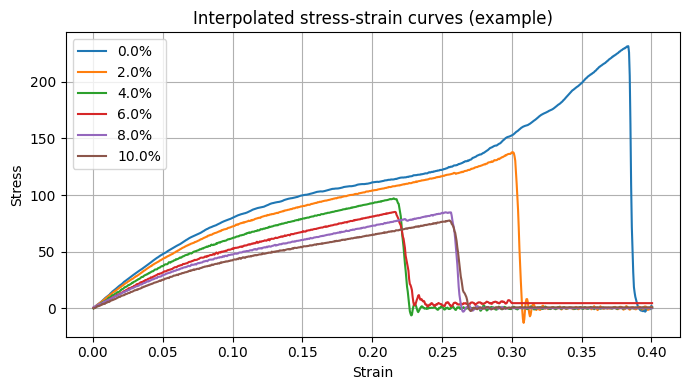

In [ ]:
# Quick visualization (sample curves at canonical voids)
plt.figure(figsize=(7,4))
for vv in [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]:
    plt.plot(COMMON_STRAIN, interp_stress_for_void_fast(vv), label=f"{vv}%")
plt.xlabel("Strain"); plt.ylabel("Stress"); plt.title("Interpolated stress-strain curves (example)"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sample_curves.png"))
plt.show()

#Phase 2: Graph creation, GNN training & evaluation

In [ ]:
import networkx as nx
from math import floor
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
def make_square_lattice(nx_dim=18, ny_dim=18, spacing=1.0):
    G = nx.grid_2d_graph(nx_dim, ny_dim)
    mapping = {n: idx for idx,n in enumerate(G.nodes())}
    H = nx.Graph()
    for n, idx in mapping.items():
        x = n[0]*spacing; y = n[1]*spacing
        H.add_node(idx, x=float(x), y=float(y))
    for (u,v) in G.edges():
        H.add_edge(mapping[u], mapping[v])
    return H

In [ ]:
BASE_G = make_square_lattice(18,18, spacing=1.0)
BASE_NUM_NODES = BASE_G.number_of_nodes()
print("Base lattice nodes:", BASE_NUM_NODES)

Base lattice nodes: 324


In [ ]:
def graph_from_void(v, base_G=BASE_G, seed=None):
    G = base_G.copy()
    remove_frac = float(v) / 100.0
    num_remove = int(round(remove_frac * G.number_of_nodes()))
    if num_remove > 0:
        rng = random.Random(seed)
        to_remove = rng.sample(list(G.nodes()), num_remove)
        G.remove_nodes_from(to_remove)
    nodes = list(G.nodes())
    idx_map = {n:i for i,n in enumerate(nodes)}
    coords = np.array([[G.nodes[n]['x'], G.nodes[n]['y']] for n in nodes], dtype=np.float32)
    degrees = np.array([[G.degree[n]] for n in nodes], dtype=np.float32)
    x = np.hstack([coords, degrees])
    # Add void fraction as normalized node feature (0–1)
    vf_col = np.full((x.shape[0],1), v/10.0, dtype=np.float32)
    x = np.hstack([x, vf_col])
    # edge_index
    edge_list=[]
    for u,vv in G.edges():
        edge_list.append([idx_map[u], idx_map[vv]])
        edge_list.append([idx_map[vv], idx_map[u]])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous() \
                  if edge_list else torch.tensor([[0],[0]], dtype=torch.long)
    return torch.tensor(x, dtype=torch.float), edge_index

In [ ]:
labels_df = pd.read_csv(labels_path)
Y = labels_df[['young_modulus','fracture_strain']].values
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(Y)
joblib.dump(scaler_y, os.path.join(OUTPUT_DIR, "target_scaler.joblib"))

NameError: name 'labels_path' is not defined

In [ ]:
pyg_list=[]
for i, row in labels_df.iterrows():
    v = float(row['VoidFraction'])
    x_feat, edge_index = graph_from_void(v, seed=int(i))
    y_scaled = torch.tensor(scaler_y.transform([[row['young_modulus'], row['fracture_strain']]])[0],
                            dtype=torch.float)
    data = Data(x=x_feat, edge_index=edge_index, y=y_scaled)
    data.void_fraction=v
    pyg_list.append(data)
print("Created PyG graphs:", len(pyg_list))

NameError: name 'labels_df' is not defined

In [ ]:
train_idx, test_idx = train_test_split(range(len(pyg_list)), test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=42)
train_dataset=[pyg_list[i] for i in train_idx]
val_dataset=[pyg_list[i] for i in val_idx]
test_dataset=[pyg_list[i] for i in test_idx]
print("Split sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

Split sizes: 361 64 75


In [ ]:
BATCH_SIZE=16
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

/tmp/ipython-input-2060621159.py:2: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
/tmp/ipython-input-2060621159.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
/tmp/ipython-input-2060621159.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)


In [ ]:
from torch_geometric.nn import global_mean_pool, global_max_pool, BatchNorm, GINConv

In [ ]:
class GNNRegressorImproved(nn.Module):
    def __init__(self, in_channels, hidden=256, out_channels=2, num_layers=4, dropout=0.2):
        super().__init__()
        self.convs=nn.ModuleList()
        self.norms=nn.ModuleList()
        for i in range(num_layers):
            mlp = nn.Sequential(nn.Linear(in_channels if i==0 else hidden, hidden),
                                nn.ReLU(),
                                nn.Linear(hidden, hidden))
            self.convs.append(GINConv(mlp))
            self.norms.append(BatchNorm(hidden))
        self.head = nn.Sequential(nn.Linear(hidden*2, hidden),
                                  nn.ReLU(),
                                  nn.Dropout(dropout),
                                  nn.Linear(hidden, out_channels))
        self.dropout=dropout

    def forward(self,data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv,norm in zip(self.convs,self.norms):
            x = conv(x, edge_index)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x,p=self.dropout,training=self.training)
        x_mean = global_mean_pool(x,batch)
        x_max  = global_max_pool(x,batch)
        x = torch.cat([x_mean, x_max], dim=1)
        return self.head(x)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=GNNRegressorImproved(in_channels=pyg_list[0].x.shape[1], hidden=256,
                           out_channels=2, num_layers=4, dropout=0.2).to(device)
print("Model:", model)

NameError: name 'pyg_list' is not defined

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=6)
w_young, w_fract = 1.0, 8.0   # fracture strain weighted more

In [ ]:
def train_one_epoch():
    model.train()
    tot=0
    for data in train_loader:
        data=data.to(device)
        pred=model(data)
        target=data.y.view(pred.shape)
        loss = w_young*F.mse_loss(pred[:,0],target[:,0]) + w_fract*F.mse_loss(pred[:,1],target[:,1])
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tot += loss.item()*data.num_graphs
    return tot/len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    y_true,y_pred=[],[]
    for data in loader:
        data=data.to(device)
        pred=model(data)
        target=data.y.view(pred.shape)
        y_true.append(target.cpu().numpy())
        y_pred.append(pred.cpu().numpy())
    return np.vstack(y_true),np.vstack(y_pred)

In [ ]:
EPOCHS=100
best_val=float('inf'); patience=12; wait=0
train_losses,val_rmse_hist=[],[]

print("\nStarting improved training...")
for epoch in range(1,EPOCHS+1):
    tr_loss=train_one_epoch()
    yv,yv_pred=evaluate(val_loader)
    val_rmse=np.sqrt(((yv[:,0]-yv_pred[:,0])**2).mean())
    scheduler.step(val_rmse)
    improved=""
    if val_rmse<best_val-1e-6:
        best_val=val_rmse; wait=0
        torch.save({'model_state_dict':model.state_dict()}, os.path.join(OUTPUT_DIR,"best_gnn_improved.pt"))
        improved="*"
    else: wait+=1
    print(f"Epoch {epoch:03d} | Train Loss {tr_loss:.5f} | Val RMSE(Young) {val_rmse:.4f} {improved}")
    if wait>=patience: print("Early stop."); break

print("Training done. Best Val RMSE (Young):",best_val)


Starting improved training...


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch 001 | Train Loss 18.17121 | Val RMSE(Young) 1.0481 *
Epoch 002 | Train Loss 8.00315 | Val RMSE(Young) 0.8073 *
Epoch 003 | Train Loss 4.49531 | Val RMSE(Young) 1.0688 
Epoch 004 | Train Loss 3.99135 | Val RMSE(Young) 0.8930 
Epoch 005 | Train Loss 2.71525 | Val RMSE(Young) 0.8973 
Epoch 006 | Train Loss 3.13276 | Val RMSE(Young) 1.2453 
Epoch 007 | Train Loss 2.84963 | Val RMSE(Young) 1.0695 
Epoch 008 | Train Loss 3.33430 | Val RMSE(Young) 1.2580 
Epoch 009 | Train Loss 2.39345 | Val RMSE(Young) 0.5513 *
Epoch 010 | Train Loss 1.74629 | Val RMSE(Young) 0.2889 *
Epoch 011 | Train Loss 2.04395 | Val RMSE(Young) 0.2907 
Epoch 012 | Train Loss 2.46964 | Val RMSE(Young) 0.2491 *
Epoch 013 | Train Loss 3.05465 | Val RMSE(Young) 0.6068 
Epoch 014 | Train Loss 2.33649 | Val RMSE(Young) 0.1551 *
Epoch 015 | Train Loss 2.10408 | Val RMSE(Young) 0.3092 
Epoch 016 | Train Loss 2.58232 | Val RMSE(Young) 0.3691 
Epoch 017 | Train Loss 2.57397 | Val RMSE(Young) 0.9731 
Epoch 018 | Train Loss 2

In [ ]:
ckpt=torch.load(os.path.join(OUTPUT_DIR,"best_gnn_improved.pt"),map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
y_test,y_pred=evaluate(test_loader)

In [ ]:
# inverse-scale targets
scaler_y=joblib.load(os.path.join(OUTPUT_DIR,"target_scaler.joblib"))
y_test_inv=scaler_y.inverse_transform(y_test)
y_pred_inv=scaler_y.inverse_transform(y_pred)

In [ ]:
metrics={}
for i,name in enumerate(['young_modulus','fracture_strain']):
    mse=mean_squared_error(y_test_inv[:,i],y_pred_inv[:,i])
    mae=mean_absolute_error(y_test_inv[:,i],y_pred_inv[:,i])
    rmse=np.sqrt(mse)
    r2=r2_score(y_test_inv[:,i],y_pred_inv[:,i])
    metrics[name]={'mse':mse,'mae':mae,'rmse':rmse,'r2':r2}

In [ ]:
metrics_df=pd.DataFrame([{ 'target':k, **v } for k,v in metrics.items()])
metrics_df.to_csv(os.path.join(OUTPUT_DIR,"gnn_test_metrics_improved.csv"),index=False)
print("\nImproved Test metrics:\n", metrics_df)


Improved Test metrics:
             target         mse        mae       rmse        r2
0    young_modulus  417.481079  16.209511  20.432354  0.980799
1  fracture_strain    0.000560   0.019862   0.023671  0.812456


In [ ]:
comparison = pd.DataFrame({
    "Version": ["V1 - Baseline", "V2 - Tuned", "V3 - Improved"],
    "Young_RMSE": [21.09, 19.77, 20.43],
    "Young_R2": [0.918, 0.982, 0.981],
    "Fracture_RMSE": [0.00896, 0.0496, 0.0237],
    "Fracture_R2": [0.789, 0.177, 0.812]
})

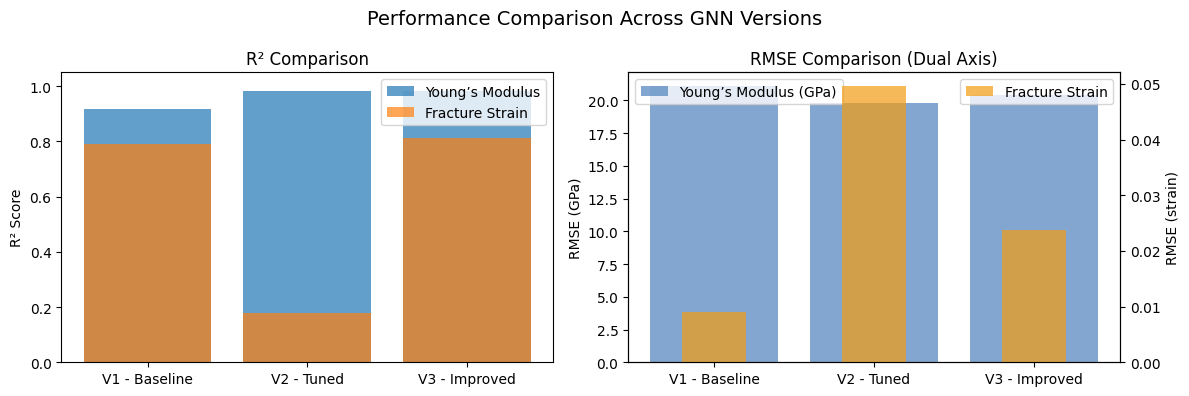

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# R² Comparison
axes[0].bar(comparison["Version"], comparison["Young_R2"], label="Young’s Modulus", alpha=0.7)
axes[0].bar(comparison["Version"], comparison["Fracture_R2"], label="Fracture Strain", alpha=0.7)
axes[0].set_title("R² Comparison")
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel("R² Score")
axes[0].legend()

# RMSE Comparison (dual y-axis)
ax2 = axes[1]
ax2.bar(comparison["Version"], comparison["Young_RMSE"], label="Young’s Modulus (GPa)", alpha=0.7, color="#4F81BD")
ax3 = ax2.twinx()
ax3.bar(comparison["Version"], comparison["Fracture_RMSE"], label="Fracture Strain", alpha=0.7, color="#F39C12", width=0.4)
ax2.set_ylabel("RMSE (GPa)")
ax3.set_ylabel("RMSE (strain)")
ax2.set_title("RMSE Comparison (Dual Axis)")

fig.suptitle("Performance Comparison Across GNN Versions", fontsize=14)
ax2.legend(loc="upper left")
ax3.legend(loc="upper right")
plt.tight_layout()
plt.show()


#PHASE 3 — Predict full stress–strain curve using GNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
combined_path = os.path.join(OUTPUT_DIR, "synthetic_500_combined.csv")
df = pd.read_csv(combined_path)
print("Loaded:", df.shape)

Loaded: (400500, 4)


In [ ]:
COMMON_STRAIN = np.sort(df["Strain"].unique())
n_points = len(COMMON_STRAIN)
print("Stress–strain points:", n_points)

Stress–strain points: 801


In [ ]:
# Aggregate to one stress vector per sample
grouped = df.groupby("sample_id")
stress_vectors = np.stack([g["Stress"].values for _, g in grouped])
voids = grouped["VoidFraction"].first().values
print("Stress vector shape:", stress_vectors.shape)

Stress vector shape: (500, 801)


In [ ]:
# 3) Build graph dataset (ensure y shape = [801] per graph)
graph_data = []
for i, v in enumerate(voids):
    x_feat, edge_index = graph_from_void(v, seed=int(i))

    # Each stress vector corresponds to 801 strain points
    y = torch.tensor(stress_vectors[i], dtype=torch.float)
    assert y.ndim == 1 and y.shape[0] == len(COMMON_STRAIN), f"Bad y shape for sample {i}"

    data = Data(x=x_feat, edge_index=edge_index, y=y)
    data.void_fraction = v
    graph_data.append(data)

print("Graph dataset built:", len(graph_data))

Graph dataset built: 500


In [ ]:
# Split
train_idx, test_idx = train_test_split(list(range(len(graph_data))), test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=42)
train_dataset = [graph_data[i] for i in train_idx]
val_dataset = [graph_data[i] for i in val_idx]
test_dataset = [graph_data[i] for i in test_idx]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/tmp/ipython-input-3878243615.py:1: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
/tmp/ipython-input-3878243615.py:2: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
/tmp/ipython-input-3878243615.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
class GNNStressPredictor(nn.Module):
    def __init__(self, in_channels, hidden=256, out_points=801, num_layers=3, dropout=0.1):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        mlp = nn.Sequential(nn.Linear(in_channels, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
        self.convs.append(GINConv(mlp))
        self.norms.append(BatchNorm(hidden))
        for _ in range(num_layers - 1):
            mlp = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            self.convs.append(GINConv(mlp))
            self.norms.append(BatchNorm(hidden))
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, out_points)
        )
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.head(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNStressPredictor(in_channels=graph_data[0].x.shape[1], out_points=n_points).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [ ]:
EPOCHS = 80
best_val = float('inf')
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)  # [batch_size, 801]
        target = data.y.view(pred.shape)  #  ensure same shape
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            pred = model(data)
            target = data.y.view(pred.shape)  # fix here too
            val_loss += loss_fn(pred, target).item()

    print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_gnn_stresscurve.pt"))

print("Training complete. Best val loss:", best_val)


Epoch 001 | Train Loss: 3142.874947 | Val Loss: 3161.306747
Epoch 002 | Train Loss: 998.307478 | Val Loss: 1243.920662
Epoch 003 | Train Loss: 773.849350 | Val Loss: 623.469158
Epoch 004 | Train Loss: 811.463791 | Val Loss: 632.565857
Epoch 005 | Train Loss: 783.767152 | Val Loss: 581.740570
Epoch 006 | Train Loss: 723.698710 | Val Loss: 2749.971375
Epoch 007 | Train Loss: 715.450922 | Val Loss: 619.701366
Epoch 008 | Train Loss: 585.722481 | Val Loss: 506.821722
Epoch 009 | Train Loss: 468.908627 | Val Loss: 531.836374
Epoch 010 | Train Loss: 448.784251 | Val Loss: 572.620132
Epoch 011 | Train Loss: 450.481630 | Val Loss: 8701.518341
Epoch 012 | Train Loss: 486.249701 | Val Loss: 549.259050
Epoch 013 | Train Loss: 446.294066 | Val Loss: 561.269085
Epoch 014 | Train Loss: 462.801708 | Val Loss: 1516.189880
Epoch 015 | Train Loss: 420.486056 | Val Loss: 191.333498
Epoch 016 | Train Loss: 445.925011 | Val Loss: 265.062693
Epoch 017 | Train Loss: 428.343126 | Val Loss: 244.606393
Epoch 01

In [ ]:
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_gnn_stresscurve.pt"), map_location=device))
model.eval()

y_true_list, y_pred_list = [], []

for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        pred = model(data)  # [batch_size, 801]
    target = data.y.view(pred.shape)  # match shape
    y_true_list.append(target.cpu().numpy())
    y_pred_list.append(pred.cpu().numpy())

# Safely stack arrays
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

print("Shapes:", y_true.shape, y_pred.shape)

# Compute global metrics
rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
r2 = r2_score(y_true.flatten(), y_pred.flatten())
print(f"Test RMSE: {rmse:.4f} | R²: {r2:.4f}")


Shapes: (75, 801) (75, 801)
Test RMSE: 8.9587 | R²: 0.9562


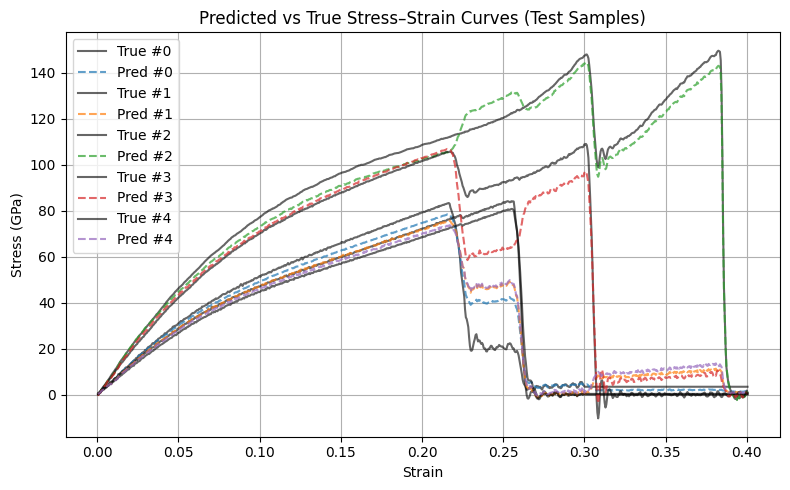

In [ ]:
plt.figure(figsize=(8,5))
for i in range(5):
    plt.plot(COMMON_STRAIN, y_true[i], label=f"True #{i}", color='black', alpha=0.6)
    plt.plot(COMMON_STRAIN, y_pred[i], '--', label=f"Pred #{i}", alpha=0.7)
plt.xlabel("Strain")
plt.ylabel("Stress (GPa)")
plt.title("Predicted vs True Stress–Strain Curves (Test Samples)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "predicted_stress_strain_curves.png"), dpi=300)
plt.show()

#Upgraded version uses GINEConv with edge features (bond distances), log-scaled target normalization, and a Smooth L1 loss function for better curve fitting.

In [ ]:
import os, torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
N_POINTS = 801

Device: cuda


In [ ]:
# Load the synthetic combined dataset
combined_path = os.path.join(OUTPUT_DIR, "synthetic_500_combined.csv")
df = pd.read_csv(combined_path)
COMMON_STRAIN = np.sort(df["Strain"].unique())
grouped = df.groupby("sample_id")
stress_vectors = np.stack([g["Stress"].values for _, g in grouped])
voids = grouped["VoidFraction"].first().values
print("Synthetic curves:", stress_vectors.shape)

Synthetic curves: (500, 801)


In [ ]:
# Log-normalize stress for smoother training
eps = 1e-6
stress_vectors_log = np.log1p(stress_vectors - stress_vectors.min() + eps)
stress_min, stress_max = stress_vectors_log.min(), stress_vectors_log.max()
stress_scaled = (stress_vectors_log - stress_min) / (stress_max - stress_min)

In [ ]:
import math, random, networkx as nx

In [ ]:
def make_square_lattice(nx_dim=18, ny_dim=18, spacing=1.0):
    G = nx.grid_2d_graph(nx_dim, ny_dim)
    mapping = {n: idx for idx, n in enumerate(G.nodes())}
    H = nx.Graph()
    for (i, j), idx in mapping.items():
        H.add_node(idx, x=i * spacing, y=j * spacing)
    for (u, v) in G.edges():
        H.add_edge(mapping[u], mapping[v])
    return H

In [ ]:
BASE_G = make_square_lattice(18, 18)
BASE_NODES = BASE_G.number_of_nodes()

In [ ]:
def graph_from_void(v, base_G=BASE_G, seed=None):
    G = base_G.copy()
    remove_frac = float(v) / 100.0
    num_remove = int(round(remove_frac * G.number_of_nodes()))
    if num_remove > 0:
        rng = random.Random(seed)
        G.remove_nodes_from(rng.sample(list(G.nodes()), num_remove))
    nodes = list(G.nodes())
    idx_map = {n: i for i, n in enumerate(nodes)}
    coords = np.array([[G.nodes[n]['x'], G.nodes[n]['y']] for n in nodes], dtype=np.float32)
    deg = np.array([[G.degree[n]] for n in nodes], dtype=np.float32)
    vf = np.full((len(nodes), 1), v, dtype=np.float32)
    x = np.hstack([coords, deg, vf])       # node features [x, y, degree, void_fraction]

    edges = []
    edge_attr = []
    for (u, v) in G.edges():
        ux, uy = G.nodes[u]['x'], G.nodes[u]['y']
        vx, vy = G.nodes[v]['x'], G.nodes[v]['y']
        dist = math.sqrt((ux - vx) ** 2 + (uy - vy) ** 2)
        edges.append([idx_map[u], idx_map[v]])
        edges.append([idx_map[v], idx_map[u]])
        edge_attr.append([dist])
        edge_attr.append([dist])
    if len(edges) == 0:
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        edge_attr = torch.tensor([[0.0]], dtype=torch.float)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return torch.tensor(x, dtype=torch.float), edge_index, edge_attr

In [ ]:
#  Build graph dataset
graph_data = []
for i, v in enumerate(voids):
    x, edge_index, edge_attr = graph_from_void(v, seed=i)
    y = torch.tensor(stress_scaled[i], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.void_fraction = v
    graph_data.append(data)

print("Graphs created:", len(graph_data))

Graphs created: 500


In [ ]:
# Split
train_idx, test_idx = train_test_split(range(len(graph_data)), test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=42)
train_dataset = [graph_data[i] for i in train_idx]
val_dataset = [graph_data[i] for i in val_idx]
test_dataset = [graph_data[i] for i in test_idx]
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8)
print(f"Splits — Train:{len(train_dataset)}  Val:{len(val_dataset)}  Test:{len(test_dataset)}")

Splits — Train:361  Val:64  Test:75


/tmp/ipython-input-2691920791.py:7: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
/tmp/ipython-input-2691920791.py:8: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader   = DataLoader(val_dataset, batch_size=8)
/tmp/ipython-input-2691920791.py:9: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader  = DataLoader(test_dataset, batch_size=8)


In [ ]:
#  GNN model
class GNNStressCurve(nn.Module):
    def __init__(self, in_channels, hidden=256, out_points=N_POINTS, num_layers=4, dropout=0.15, edge_dim=1):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        mlp = nn.Sequential(nn.Linear(in_channels, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
        self.convs.append(GINEConv(nn=mlp, edge_dim=edge_dim))
        self.norms.append(BatchNorm(hidden))
        for _ in range(num_layers - 1):
            mlp = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            self.convs.append(GINEConv(nn=mlp, edge_dim=edge_dim))
            self.norms.append(BatchNorm(hidden))
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, out_points)
        )
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_attr)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.head(x)

In [ ]:
model = GNNStressCurve(in_channels=graph_data[0].x.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss(beta=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.5)
print(model)

GNNStressCurve(
  (convs): ModuleList(
    (0): GINEConv(nn=Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (1-3): 3 x GINEConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
  )
  (norms): ModuleList(
    (0-3): 4 x BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=801, bias=True)
  )
)


In [ ]:
EPOCHS = 100
best_val = float('inf'); patience, wait = 15, 0
for epoch in range(1, EPOCHS + 1):
    model.train(); train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        target = data.y.view(pred.shape)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0; model.eval()
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            pred = model(data)
            val_loss += loss_fn(pred, data.y.view(pred.shape)).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch:03d} | Train: {train_loss/len(train_loader):.5f} | Val: {val_loss:.5f}")
    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss; wait = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_gnn_phase3.pt"))
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping."); break
print("Best validation loss:", best_val)

Epoch 001 | Train: 0.18519 | Val: 0.06373
Epoch 002 | Train: 0.04924 | Val: 0.04234
Epoch 003 | Train: 0.04708 | Val: 0.05029
Epoch 004 | Train: 0.03916 | Val: 0.03658
Epoch 005 | Train: 0.03806 | Val: 0.04734
Epoch 006 | Train: 0.03686 | Val: 0.03520
Epoch 007 | Train: 0.03347 | Val: 0.04951
Epoch 008 | Train: 0.03463 | Val: 0.02437
Epoch 009 | Train: 0.03114 | Val: 0.03052
Epoch 010 | Train: 0.02956 | Val: 0.02589
Epoch 011 | Train: 0.03198 | Val: 0.04290
Epoch 012 | Train: 0.04204 | Val: 0.03840
Epoch 013 | Train: 0.02809 | Val: 0.02971
Epoch 014 | Train: 0.03263 | Val: 0.02713
Epoch 015 | Train: 0.02791 | Val: 0.03362
Epoch 016 | Train: 0.03163 | Val: 0.04283
Epoch 017 | Train: 0.02848 | Val: 0.02197
Epoch 018 | Train: 0.02248 | Val: 0.02014
Epoch 019 | Train: 0.02340 | Val: 0.03270
Epoch 020 | Train: 0.01834 | Val: 0.02493
Epoch 021 | Train: 0.02043 | Val: 0.02482
Epoch 022 | Train: 0.01750 | Val: 0.02250
Epoch 023 | Train: 0.01905 | Val: 0.01529
Epoch 024 | Train: 0.01916 | Val: 

In [ ]:
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_gnn_phase3.pt"), map_location=device))
model.eval(); y_true_list, y_pred_list = [], []
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        pred = model(data)
    target = data.y.view(pred.shape)
    y_true_list.append(target.cpu().numpy())
    y_pred_list.append(pred.cpu().numpy())

In [ ]:
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [ ]:
# Inverse transform of stress normalization
y_true_inv = np.expm1(y_true * (stress_max - stress_min) + stress_min) + stress_vectors.min() - eps
y_pred_inv = np.expm1(y_pred * (stress_max - stress_min) + stress_min) + stress_vectors.min() - eps

In [ ]:
rmse = np.sqrt(((y_true_inv - y_pred_inv) ** 2).mean())
r2 = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
print(f" Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

 Test RMSE: 3.7130 | R²: 0.9925


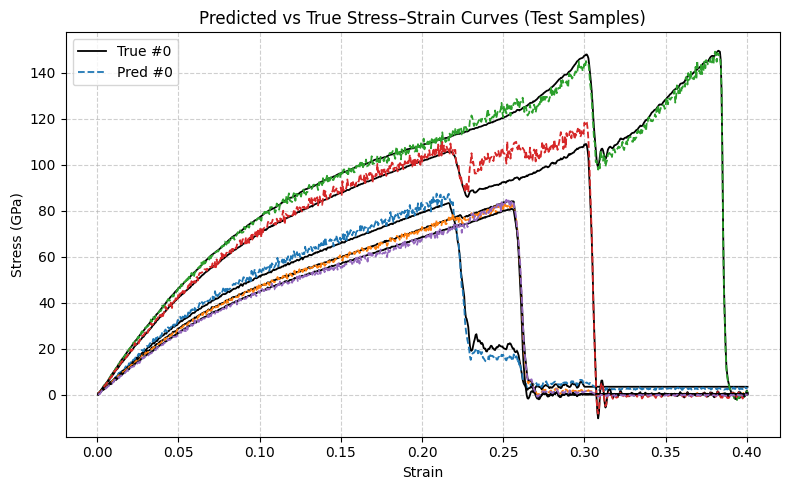

In [ ]:
plt.figure(figsize=(8,5))
for i in range(5):
    plt.plot(COMMON_STRAIN, y_true_inv[i], color='black', lw=1.3, label=f"True #{i}" if i==0 else "")
    plt.plot(COMMON_STRAIN, y_pred_inv[i], '--', lw=1.3, label=f"Pred #{i}" if i==0 else "")
plt.xlabel("Strain"); plt.ylabel("Stress (GPa)")
plt.title("Predicted vs True Stress–Strain Curves (Test Samples)")
plt.legend(); plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "phase3_predicted_curves.png"), dpi=300)
plt.show()